# S&P 500 Trading Algorithm

This notebook implements a trading algorithm for the S&P 500 using machine learning models. We will use available parameters as signals and build models like FFNN, Auto-Encoder, LSTM, and CNN.

## Data Loading and Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Expermient 1: Use all signals to predict the S&P 500 index:

In [2]:

# Load the CSV data
data = pd.read_csv("output.csv")

# Print the columns to understand the data structure
print("Data Columns:")
print(data.columns)

# Based on the legend, we should map these columns to lowercase
selected_columns = [
    'emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year',
    'mov', 'ir', 'rr',
    'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un',
    'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf',
    '_au', '_dxy', '_lcp', '_ty', '_oil',
    '_mkt', '_va', '_gr'
]

# Check if the selected columns are in the data
available_columns = [col for col in selected_columns if col in data.columns]
print("Selected Available Columns:")
print(available_columns)

# Extracting the relevant columns
data = data[available_columns + ['snp']]  # Including 'snp' as target

Data Columns:
Index(['emp', 'pe', 'cape', 'dy', 'rho', 'mov', 'ir', 'rr', 'y02', 'y10',
       'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss',
       'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr',
       'snp', 'date', 'year', 'month', 'day', 'label'],
      dtype='object')
Selected Available Columns:
['emp', 'pe', 'cape', 'dy', 'rho', 'day', 'month', 'year', 'mov', 'ir', 'rr', 'y02', 'y10', 'stp', 'cf', 'mg', 'rv', 'ed', 'un', 'gdp', 'm2', 'cpi', 'dil', 'yss', 'nyf', '_au', '_dxy', '_lcp', '_ty', '_oil', '_mkt', '_va', '_gr']


## Preprocess and Feature Engineering

In [3]:
# Handle missing values
data = data.dropna()

# Extract features and target
features = data.drop(columns=['snp'])
target = data['snp']

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

print("Feature Engineering and Data Preprocessing Complete.")


Feature Engineering and Data Preprocessing Complete.


## Custom Train-Test Split for LSTM To Keep Data Sequential

In [4]:

def custom_train_test_split_with_indices(features, target, sequence_length=10, test_size=0.2):
    # Create sequences
    sequences = []
    labels = []
    indices = []
    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        labels.append(target[i+sequence_length])
        indices.append(i+sequence_length)
    
    X = np.array(sequences)
    y = np.array(labels)
    indices = np.array(indices)
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, indices, test_size=test_size, random_state=42
    )
    
    # Reshape data for LSTM (needs 3D input: [samples, time steps, features])
    X_train_lstm_prepared = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test_lstm_prepared = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    y_train_lstm_prepared = y_train
    y_test_lstm_prepared = y_test
    
    return (X_train_lstm_prepared, y_train_lstm_prepared, train_indices,
            X_test_lstm_prepared, y_test_lstm_prepared, test_indices)

# Use the function
X_train_lstm_prepared, y_train_lstm_prepared, train_indices, X_test_lstm_prepared, y_test_lstm_prepared, test_indices = custom_train_test_split_with_indices(features_scaled, target)

## Model Implementation

### Feed-Forward Neural Network (FFNN)

Epoch 1/400


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3733235.5000 - val_loss: 3798410.2500
Epoch 2/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3498731.5000 - val_loss: 3620072.2500
Epoch 3/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3377329.2500 - val_loss: 3287623.0000
Epoch 4/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3279521.2500 - val_loss: 2818585.0000
Epoch 5/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2512100.7500 - val_loss: 2189740.5000
Epoch 6/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2042452.1250 - val_loss: 1492216.1250
Epoch 7/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1318807.1250 - val_loss: 841879.0000
Epoch 8/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 780441.5000 - val_loss: 360475.0312
Epoch 9/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 348993.8438 - val_loss: 174483.7812
Epoch 10/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 220228.1875 - val_loss: 133792.9219
Epoch 11/400
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

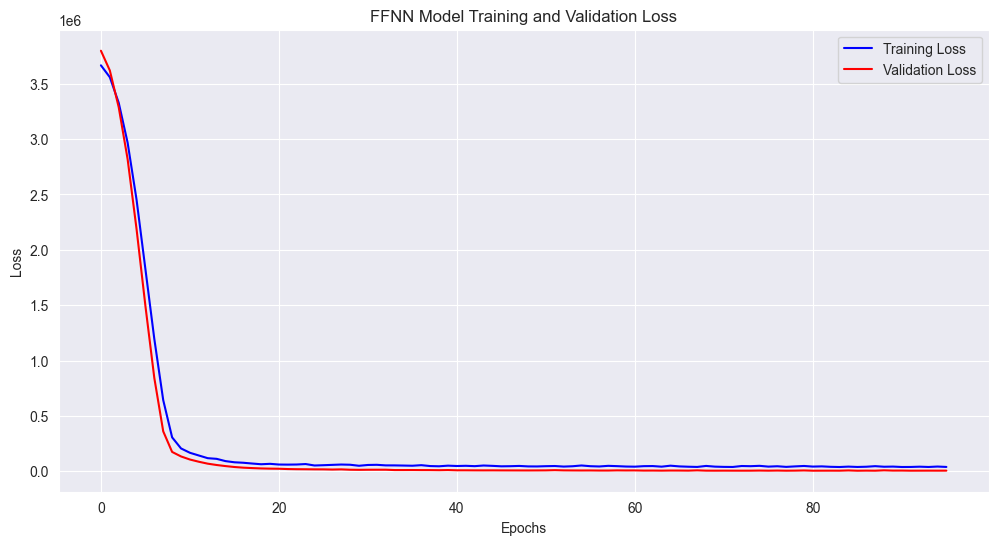

In [5]:

# Define the FFNN model creation function

def create_ffnn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
    return model

# Training with all parameters
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ffnn_model = create_ffnn_model(X_train_scaled.shape[1])
ffnn_history = ffnn_model.fit(X_train_scaled, y_train, epochs=400, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation = ffnn_model.evaluate(X_test_scaled, y_test)
print(f"FFNN Model Test Loss: {ffnn_evaluation}")

ffnn_predictions = ffnn_model.predict(X_test_scaled)
print("FFNN Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(ffnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('FFNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Long Short-Term Memory Network (LSTM)

Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3873731.7500 - val_loss: 3929692.5000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3752705.5000 - val_loss: 3847035.7500
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3698922.2500 - val_loss: 3702516.5000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3223866.5000 - val_loss: 3585510.5000
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3366925.0000 - val_loss: 3389854.7500
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3116521.7500 - val_loss: 3040170.2500
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2861707.7500 - val_loss: 2598665.5000
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2300916.7500 - val_loss: 2258673.7500
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1948046.8750 - val_loss: 1456308.5000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1762772.2500 - val_loss: 1247496.1250
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

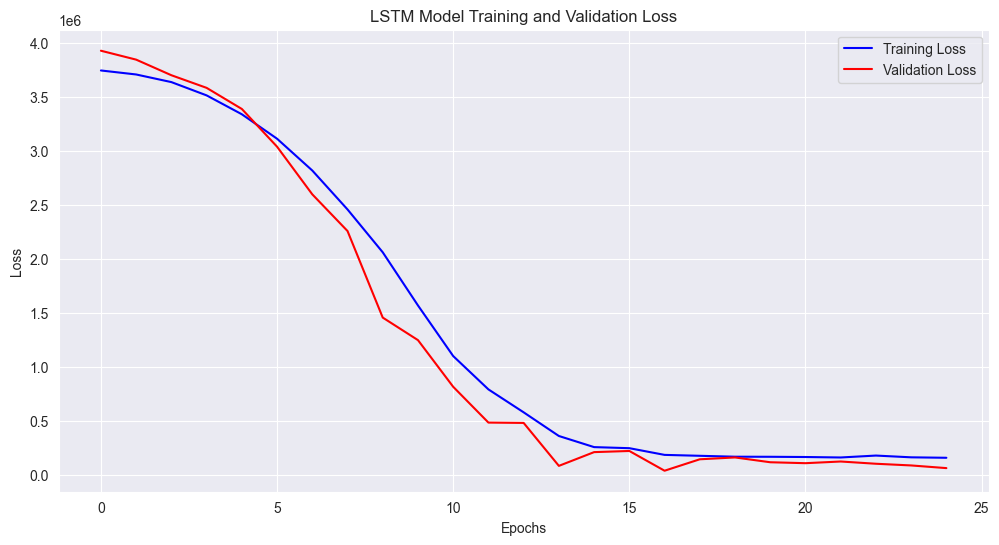

In [6]:
# Define the LSTM model creation function
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))  # Add dropout for regularization
    model.add(BatchNormalization())  # Add batch normalization
    model.add(Dense(32, activation='relu'))  # Add an additional dense layer
    model.add(Dropout(0.3))  # Add another dropout for regularization
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
lstm_model = create_lstm_model((X_train_lstm_prepared.shape[1], X_train_lstm_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train_lstm_prepared, y_train_lstm_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])

lstm_evaluation = lstm_model.evaluate(X_test_lstm_prepared, y_test_lstm_prepared)
print(f"LSTM Model Test Loss: {lstm_evaluation}")

lstm_predictions = lstm_model.predict(X_test_lstm_prepared)
print("LSTM Model Training and Evaluation Complete.")

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss', color='blue')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Convolutional Neural Network (CNN)

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2939132.2500 - val_loss: 966059.1250
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 911103.1250 - val_loss: 398413.5312
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 323989.8438 - val_loss: 172060.2969
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 183708.7656 - val_loss: 126098.3594
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 128756.1953 - val_loss: 102850.7109
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 107840.0078 - val_loss: 99068.7422
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 95810.3672 - val_loss: 74037.2031
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75552.2188 - val_loss: 58908.3125
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59799.7188 - val_loss: 43033.4141
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 46027.1836 - val_loss: 30486.6133
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36616.09

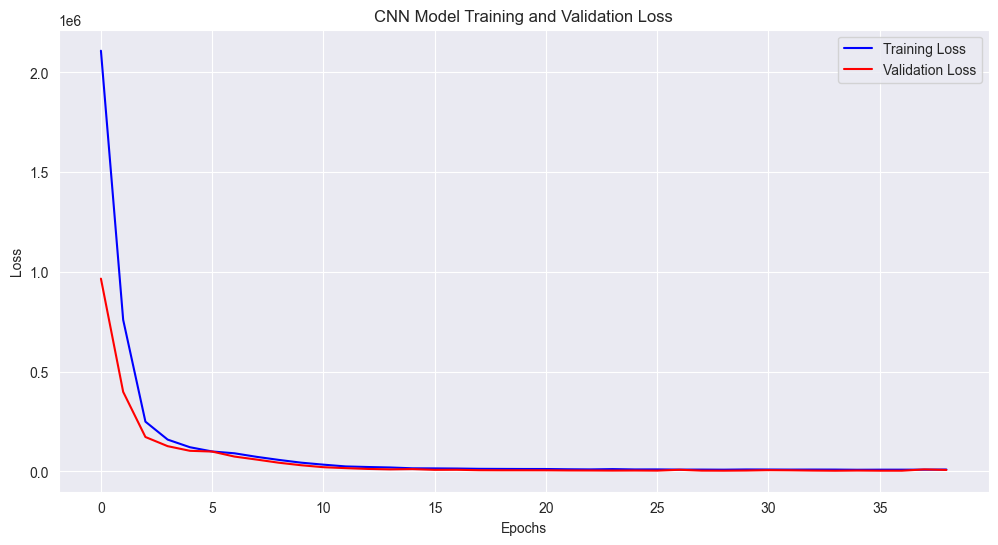

In [7]:

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Define the CNN model creation function
def create_cnn_model(input_dim):
    model = Sequential()
    model.add(Reshape((input_dim, 1), input_shape=(input_dim,)))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Dropout(0.25))  # Dropout layer to reduce overfitting
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Training with all parameters
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model = create_cnn_model(X_train_scaled.shape[1])
cnn_history = cnn_model.fit(X_train_scaled, y_train, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation = cnn_model.evaluate(X_test_scaled, y_test)
print(f"CNN Model Test Loss: {cnn_evaluation}")

cnn_predictions = cnn_model.predict(X_test_scaled)
print("CNN Model Training and Evaluation Complete.")

plt.figure(figsize=(12, 6))
plt.plot(cnn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('CNN Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Auto-encoder

Different data pre-rocessing and model implementation for autoencoder

Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1244 - val_loss: 0.0407
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466 - val_loss: 0.0224
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0328 - val_loss: 0.0188
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0271 - val_loss: 0.0165
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0153
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0213 - val_loss: 0.0132
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.0115
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0103
Epoch 9/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.0092
Epoch 10/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - val_loss: 0.0089
Epoch 11/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0088
Epoch 12/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_lo

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3619275.2500 - val_loss: 3867222.5000
Epoch 2/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3706813.7500 - val_loss: 3864162.2500
Epoch 3/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3636325.7500 - val_loss: 3862625.0000
Epoch 4/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3613560.0000 - val_loss: 3862389.0000
Epoch 5/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3631093.5000 - val_loss: 3860072.2500
Epoch 6/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3584233.0000 - val_loss: 3857619.0000
Epoch 7/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3890536.7500 - val_loss: 3848691.7500
Epoch 8/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3562048.0000 - val_loss: 3838714.5000
Epoch 9/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3475123.5000 - val_loss: 3830465.2500
Epoch 10/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3532420.5000 - val_loss: 3811092.7500
Epoch 11/250
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

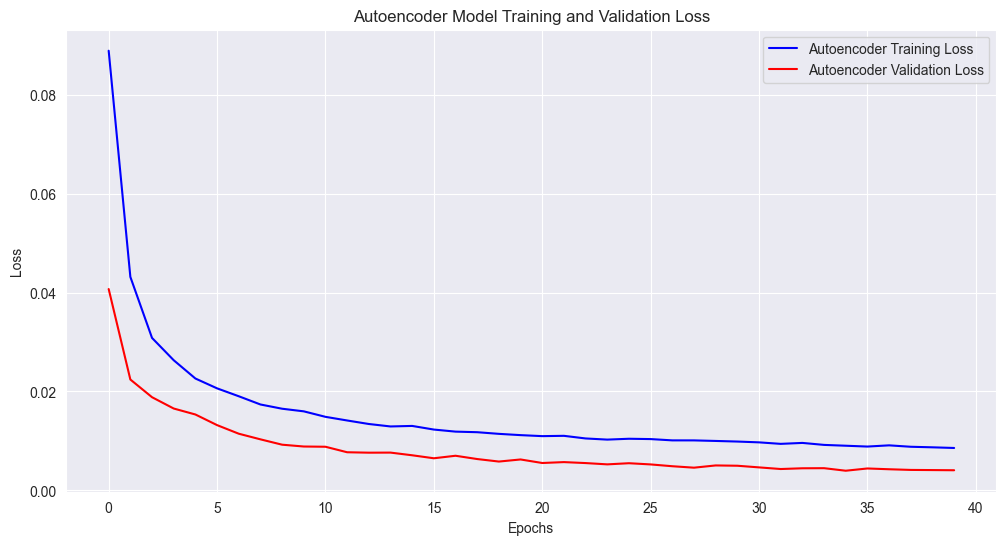

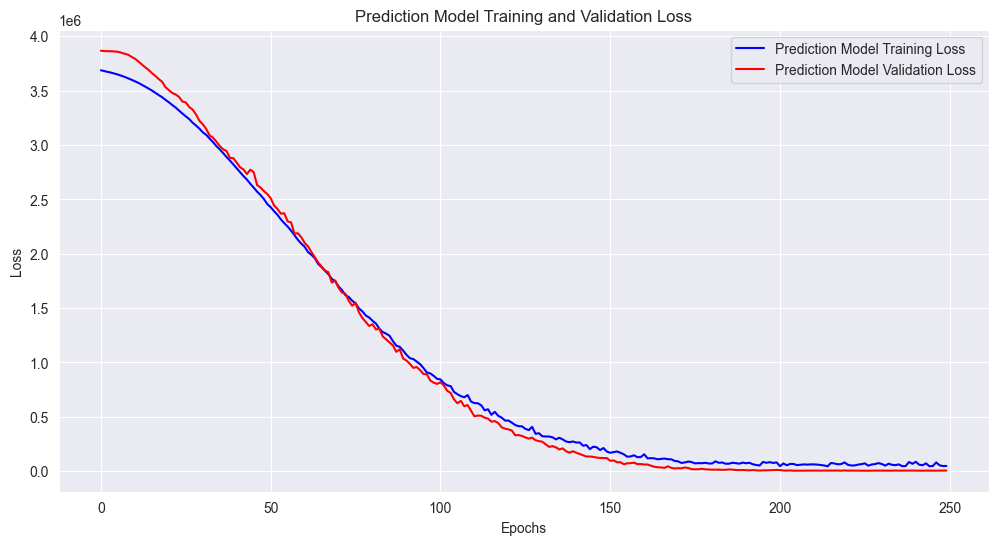

In [8]:
# Define the autoencoder model creation function
def create_autoencoder_model(input_dim, encoding_dim=32):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dropout(0.25)(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dropout(0.25)(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    # Autoencoder
    autoencoder = Model(input_layer, decoded)

    # Separate encoder model
    encoder = Model(input_layer, encoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return autoencoder, encoder

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the autoencoder
input_dim = X_train_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])

# Encode the data
X_train_encoded = encoder.predict(X_train_scaled)
X_test_encoded = encoder.predict(X_test_scaled)

# Train a simple model to predict S&P using encoded features
prediction_model = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

prediction_model.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

prediction_history = prediction_model.fit(X_train_encoded, y_train,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = prediction_model.evaluate(X_test_encoded, y_test)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_predictions = prediction_model.predict(X_test_encoded)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Autoencoder Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Autoencoder Validation Loss', color='red')
plt.title('Autoencoder Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(prediction_history.history['loss'], label='Prediction Model Training Loss', color='blue')
plt.plot(prediction_history.history['val_loss'], label='Prediction Model Validation Loss', color='red')
plt.title('Prediction Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluate models with MSE, Sharpe ratio, R2 and IC

Get the in-sample and out-of-sample R-Squared and MSE
The Information Coefficient (IC) measures the correlation between predicted and actual returns.
see: https://www.investopedia.com/terms/i/information-coefficient.asp
#### Sharpe Ratio
The Sharpe ratio is a measure of risk-adjusted return, calculated as the average return earned in excess of the risk-free rate per unit of volatility or total risk. 


In [9]:

def calculate_proportion_correct(predictions, actuals):
    predictions = predictions.flatten()
    actuals = actuals
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    proportion_correct = np.mean(correct_predictions)
    return proportion_correct

def calculate_ic(proportion_correct):
    return (2 * proportion_correct) - 1

def calculate_sharpe_ratio(predictions, actuals, risk_free_rate=0):
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    strategy_returns = []
    for t in range(1, len(predictions)):
        if predictions[t-1] <= predictions[t] and actuals[t-1] <= actuals[t]:
            strategy_returns.append(actuals[t] - actuals[t-1])  # Long position
        elif predictions[t-1] > predictions[t] and actuals[t-1] > actuals[t]:
            strategy_returns.append(actuals[t-1] - actuals[t])  # Short position
        else:
            strategy_returns.append(0)  # No position
    
    strategy_returns = np.array(strategy_returns)
    
    mean_return = np.mean(strategy_returns)
    std_dev = np.std(strategy_returns)
    
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    
    return sharpe_ratio


scaler_cnn_pred = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_cnn_pred.fit_transform(X_train)
# Evaluate in-sample predictions
ffnn_train_predictions = ffnn_model.predict(X_train)
lstm_train_predictions = lstm_model.predict(X_train_lstm_prepared)
cnn_train_predictions = cnn_model.predict(X_train_scaled)
autoencoder_train_predictions = prediction_model.predict(X_train_encoded)

# # Ensure the length consistency of predictions and actuals
# def ensure_length_consistency(predictions, actuals):
#     min_length = min(len(predictions), len(actuals))
#     return predictions[:min_length], actuals[:min_length]

# FFNN performance
# ffnn_predictions, y_test = ensure_length_consistency(ffnn_predictions, y_test)
ffnn_in_sample_r2 = r2_score(y_train, ffnn_train_predictions)
ffnn_out_sample_r2 = r2_score(y_test, ffnn_predictions)
ffnn_in_sample_mse = mean_squared_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_in_sample_mae = mean_absolute_error(y_train, ffnn_train_predictions)
ffnn_out_sample_mae = mean_absolute_error(y_test, ffnn_predictions)

# LSTM performance
# lstm_predictions, y_test_lstm_prepared = ensure_length_consistency(lstm_predictions, y_test_lstm_prepared)
lstm_in_sample_r2 = r2_score(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_r2 = r2_score(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mse = mean_squared_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mse = mean_squared_error(y_test_lstm_prepared, lstm_predictions)
lstm_in_sample_mae = mean_absolute_error(y_train_lstm_prepared, lstm_train_predictions)
lstm_out_sample_mae = mean_absolute_error(y_test_lstm_prepared, lstm_predictions)

# CNN performance
# cnn_predictions, y_test = ensure_length_consistency(cnn_predictions, y_test)
cnn_in_sample_r2 = r2_score(y_train, cnn_train_predictions)
cnn_out_sample_r2 = r2_score(y_test, cnn_predictions)
cnn_in_sample_mse = mean_squared_error(y_train, cnn_train_predictions)
cnn_out_sample_mse = mean_squared_error(y_test, cnn_predictions)
cnn_in_sample_mae = mean_absolute_error(y_train, cnn_train_predictions)
cnn_out_sample_mae = mean_absolute_error(y_test, cnn_predictions)

# Autoencoder performance
# autoencoder_predictions, y_test = ensure_length_consistency(autoencoder_predictions, y_test)
autoencoder_in_sample_r2 = r2_score(y_train, autoencoder_train_predictions)
autoencoder_out_sample_r2 = r2_score(y_test, autoencoder_predictions)
autoencoder_in_sample_mse = mean_squared_error(y_train, autoencoder_train_predictions)
autoencoder_out_sample_mse = mean_squared_error(y_test, autoencoder_predictions)
autoencoder_in_sample_mae = mean_absolute_error(y_train, autoencoder_train_predictions)
autoencoder_out_sample_mae = mean_absolute_error(y_test, autoencoder_predictions)

# Proportion correct and IC calculations
ffnn_in_sample_proportion_correct = calculate_proportion_correct(ffnn_train_predictions, y_train)
ffnn_out_sample_proportion_correct = calculate_proportion_correct(ffnn_predictions, y_test)
ffnn_in_sample_ic = calculate_ic(ffnn_in_sample_proportion_correct)
ffnn_out_sample_ic = calculate_ic(ffnn_out_sample_proportion_correct)

lstm_in_sample_proportion_correct = calculate_proportion_correct(lstm_train_predictions, y_train_lstm_prepared)
lstm_out_sample_proportion_correct = calculate_proportion_correct(lstm_predictions, y_test_lstm_prepared)
lstm_in_sample_ic = calculate_ic(lstm_in_sample_proportion_correct)
lstm_out_sample_ic = calculate_ic(lstm_out_sample_proportion_correct)

cnn_in_sample_proportion_correct = calculate_proportion_correct(cnn_train_predictions, y_train)
cnn_out_sample_proportion_correct = calculate_proportion_correct(cnn_predictions, y_test)
cnn_in_sample_ic = calculate_ic(cnn_in_sample_proportion_correct)
cnn_out_sample_ic = calculate_ic(cnn_out_sample_proportion_correct)

autoencoder_in_sample_proportion_correct = calculate_proportion_correct(autoencoder_train_predictions, y_train)
autoencoder_out_sample_proportion_correct = calculate_proportion_correct(autoencoder_predictions, y_test)
autoencoder_in_sample_ic = calculate_ic(autoencoder_in_sample_proportion_correct)
autoencoder_out_sample_ic = calculate_ic(autoencoder_out_sample_proportion_correct)

# Sharpe ratio calculations
ffnn_sharpe = calculate_sharpe_ratio(ffnn_predictions, y_test)
lstm_sharpe = calculate_sharpe_ratio(lstm_predictions, y_test_lstm_prepared)
cnn_sharpe = calculate_sharpe_ratio(cnn_predictions, y_test)
autoencoder_sharpe = calculate_sharpe_ratio(autoencoder_predictions, y_test)

# Create a table for all metrics
metrics_data = {
    "Model": ["FFNN", "LSTM", "CNN", "Autoencoder"],
    "In-sample MSE": [ffnn_in_sample_mse, lstm_in_sample_mse, cnn_in_sample_mse, autoencoder_in_sample_mse],
    "Out-sample MSE": [ffnn_out_sample_mse, lstm_out_sample_mse, cnn_out_sample_mse, autoencoder_out_sample_mse],
    "In-sample R2": [ffnn_in_sample_r2, lstm_in_sample_r2, cnn_in_sample_r2, autoencoder_in_sample_r2],
    "Out-sample R2": [ffnn_out_sample_r2, lstm_out_sample_r2, cnn_out_sample_r2, autoencoder_out_sample_r2],
    "In-sample MAE": [ffnn_in_sample_mae, lstm_in_sample_mae, cnn_in_sample_mae, autoencoder_in_sample_mae],
    "Out-sample MAE": [ffnn_out_sample_mae, lstm_out_sample_mae, cnn_out_sample_mae, autoencoder_out_sample_mae],
    "In-sample IC": [ffnn_in_sample_ic, lstm_in_sample_ic, cnn_in_sample_ic, autoencoder_in_sample_ic],
    "Out-sample IC": [ffnn_out_sample_ic, lstm_out_sample_ic, cnn_out_sample_ic, autoencoder_out_sample_ic],
    "Sharpe Ratio": [ffnn_sharpe, lstm_sharpe, cnn_sharpe, autoencoder_sharpe]
}

metrics_df = pd.DataFrame(metrics_data)
display(metrics_df)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample MAE,Out-sample MAE,In-sample IC,Out-sample IC,Sharpe Ratio
0,FFNN,6329.271910,7775.059490,0.995128,0.994754,54.752632,59.525596,0.938870,0.920213,1.077655
1,LSTM,39192.407945,44233.980612,0.970502,0.967369,159.910848,168.749244,0.909152,0.903743,1.119961
2,CNN,4526.014724,6054.382905,0.996516,0.995915,44.030710,47.123571,0.950831,0.941489,1.080053
3,Autoencoder,5345.172640,8226.361492,0.995886,0.994449,49.536464,57.406967,0.949502,0.952128,1.079583


## Show the Actual vs. Predicted Values
We will create charts to visualize the actual vs. predicted values for each model and discuss the results.

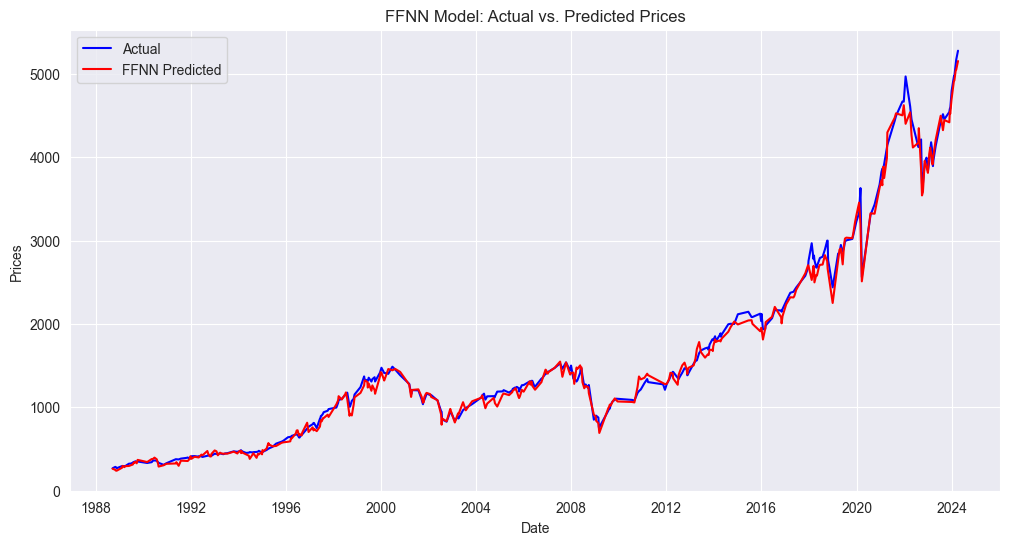

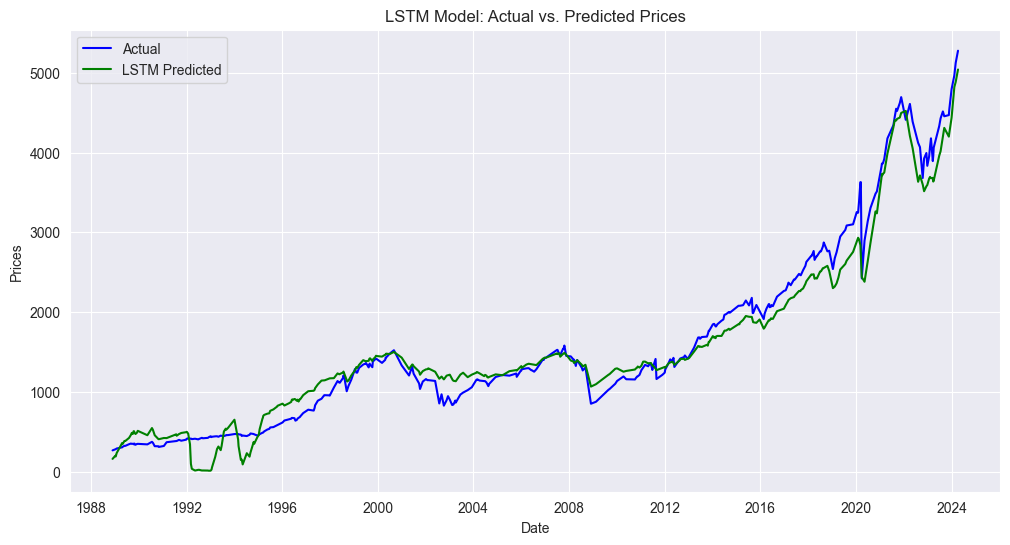

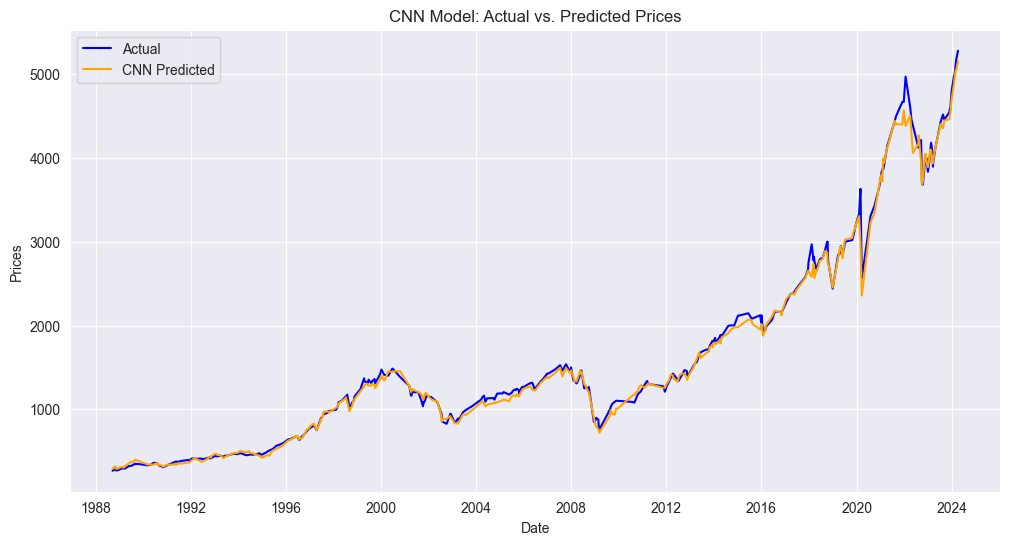

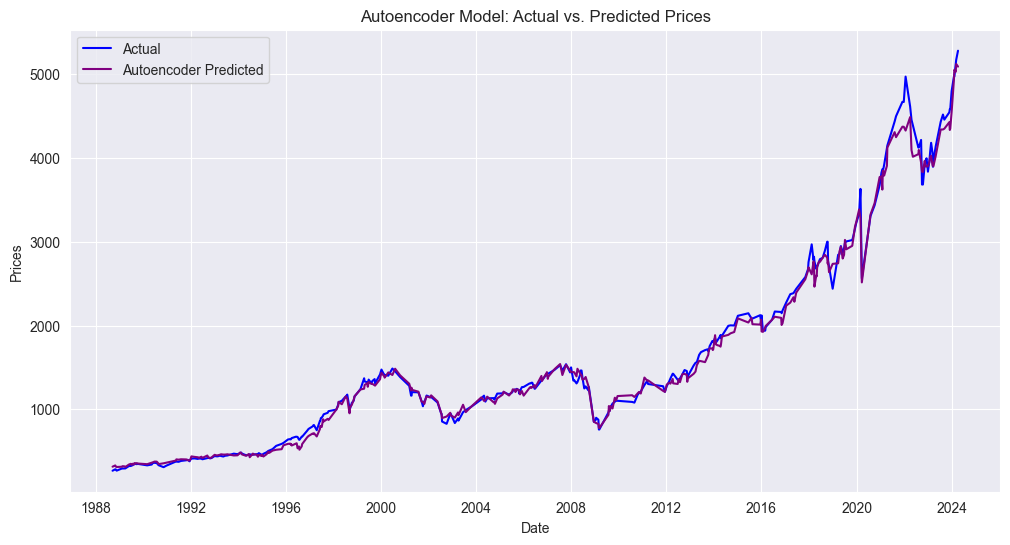

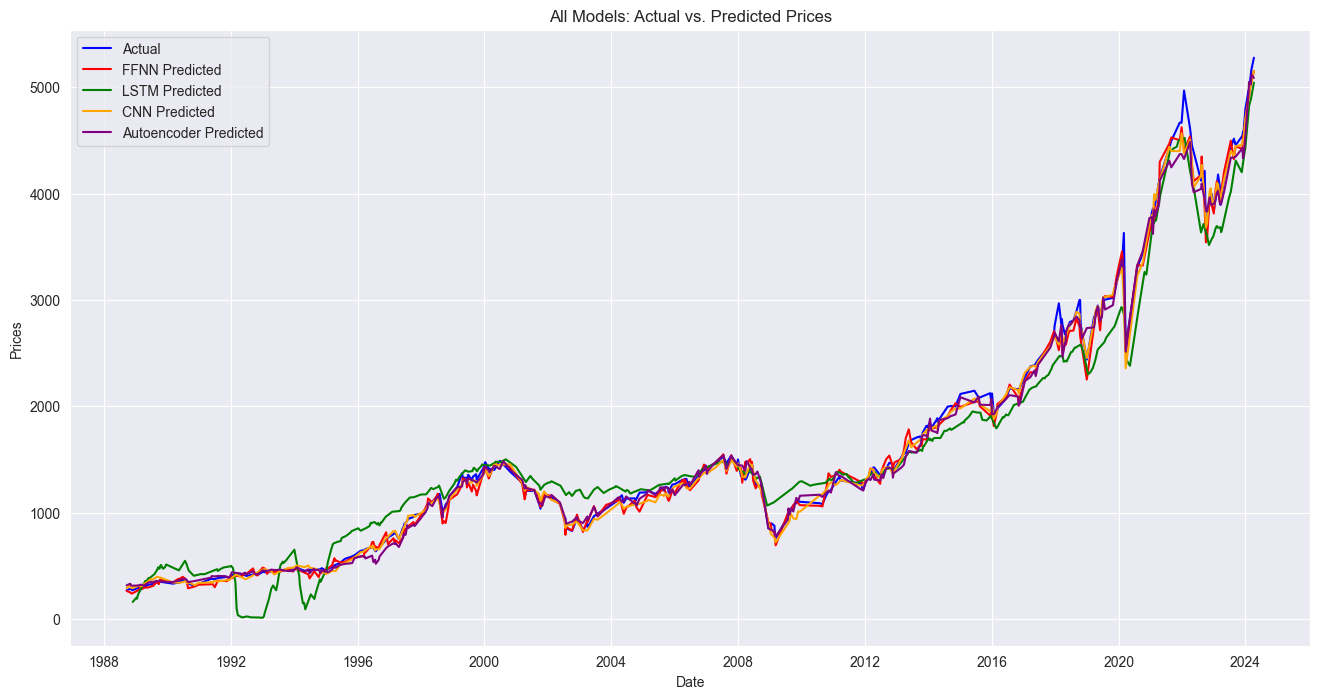

In [10]:
# Step 1: Create a Date column from 'day', 'month', and 'year'
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Ensure all predictions and actuals are 1-dimensional
y_test_series = pd.Series(y_test.squeeze(), index=y_test.index, name='Actual')
y_test_lstm_series = pd.Series(y_test_lstm_prepared.squeeze(), index=y_test_lstm_prepared, name='Actual')
ffnn_predictions_flat = ffnn_predictions.flatten()
lstm_predictions_flat = lstm_predictions.flatten()
cnn_predictions_flat = cnn_predictions.flatten()
autoencoder_predictions_flat = autoencoder_predictions.flatten()

# Create DataFrame for y_test and ffnn_predictions
ffnn_test_df = pd.DataFrame({
    'Actual': y_test_series.values,
    'FFNN_Predicted': ffnn_predictions_flat
}, index=y_test_series.index)

# Merge ffnn_test_df with the original data using the index
ffnn_merged_df = data.join(ffnn_test_df, how='inner')

# Plot actual vs. predicted values for FFNN
plt.figure(figsize=(12, 6))
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['Actual'], label='Actual', color='blue')
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['FFNN_Predicted'], label='FFNN Predicted', color='red')
plt.title('FFNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# LSTM plot
lstm_test_df = pd.DataFrame({
    'Date_lstm': data.loc[test_indices, 'Date'].values,
    'Actual_lstm': y_test_lstm_prepared,
    'LSTM_Predicted': lstm_predictions.flatten()
}, index=test_indices)

lstm_merged_df = data.join(lstm_test_df, how='inner', lsuffix='_orig', rsuffix='_lstm')

plt.figure(figsize=(12, 6))
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['Actual_lstm'], label='Actual', color='blue')
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['LSTM_Predicted'], label='LSTM Predicted', color='green')
plt.title('LSTM Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# CNN plot
cnn_test_df = pd.DataFrame({
    'Date_cnn': data.loc[y_test.index, 'Date'].values,
    'Actual_cnn': y_test.values,
    'CNN_Predicted': cnn_predictions.flatten()
}, index=y_test.index)

cnn_merged_df = data.join(cnn_test_df, how='inner', lsuffix='_orig', rsuffix='_cnn')

plt.figure(figsize=(12, 6))
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['Actual_cnn'], label='Actual', color='blue')
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['CNN_Predicted'], label='CNN Predicted', color='orange')
plt.title('CNN Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Autoencoder plot
autoencoder_test_df = pd.DataFrame({
    'Date_autoencoder': data.loc[y_test.index, 'Date'].values,
    'Actual_autoencoder': y_test.values,
    'Autoencoder_Predicted': autoencoder_predictions_flat
}, index=y_test.index)

autoencoder_merged_df = data.join(autoencoder_test_df, how='inner', lsuffix='_orig', rsuffix='_autoencoder')

plt.figure(figsize=(12, 6))
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Actual_autoencoder'], label='Actual', color='blue')
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Autoencoder_Predicted'], label='Autoencoder Predicted', color='purple')
plt.title('Autoencoder Model: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# Combined plot of all models
plt.figure(figsize=(16, 8))
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['Actual'], label='Actual', color='blue')
plt.plot(ffnn_merged_df['Date'], ffnn_merged_df['FFNN_Predicted'], label='FFNN Predicted', color='red')
plt.plot(lstm_merged_df['Date_lstm'], lstm_merged_df['LSTM_Predicted'], label='LSTM Predicted', color='green')
plt.plot(cnn_merged_df['Date_cnn'], cnn_merged_df['CNN_Predicted'], label='CNN Predicted', color='orange')
plt.plot(autoencoder_merged_df['Date_autoencoder'], autoencoder_merged_df['Autoencoder_Predicted'], label='Autoencoder Predicted', color='purple')
plt.title('All Models: Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Interpretation of Results:
The charts show the actual vs. predicted values for each model (FFNN, LSTM, CNN). The models' predictions are compared to the actual S&P 500 index values. The visualizations help understand the models' performance in predicting the stock market movements. 

# Use Multiple Sets of Signals (Experiment 2&3)
We will evaluate the models using two sets of signals:

### Set 1: Macroeconomic Signals:

GDP: Gross Domestic Product growth.
CPI: Inflation rate.
UN: Unemployment rate.
IR: Nominal interest rate.
Y10: 10Y treasury yield.
Economic Motivation: These indicators are fundamental to the overall economic environment and can significantly influence stock market movements. Changes in GDP, inflation, and interest rates are closely monitored by investors.

### Set 2: Market and Technical Signals:

PE: Price/Earnings ratio.
DY: Dividend yield.
_MKT: Market returns.
_VA: Value index.
_GR: Growth index.
Economic Motivation: These indicators provide insight into market valuation and performance. They help understand the relative attractiveness of stocks and the broader market trends.

We will re-train and evaluate the models using these sets of signals.

## FFNN

In [11]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ffnn_model_macro = create_ffnn_model(X_train_macro.shape[1])
ffnn_history_macro = ffnn_model_macro.fit(X_train_macro, y_train_macro, epochs=200, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation_macro = ffnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"FFNN Model with Macro Signals Test Loss: {ffnn_evaluation_macro}")

ffnn_macro_predictions = ffnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

ffnn_model_market = create_ffnn_model(X_train_market.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ffnn_history_market = ffnn_model_market.fit(X_train_market, y_train_market, epochs=300, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

ffnn_evaluation_market = ffnn_model_market.evaluate(X_test_market, y_test_market)
print(f"FFNN Model with Market Signals Test Loss: {ffnn_evaluation_market}")

ffnn_market_predictions = ffnn_model_market.predict(X_test_market)



Epoch 1/200


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3717651.5000 - val_loss: 3754075.5000
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3581961.5000 - val_loss: 3514948.2500
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3411567.0000 - val_loss: 3097218.5000
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2852748.5000 - val_loss: 2516868.0000
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2287806.7500 - val_loss: 1890709.7500
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1716147.8750 - val_loss: 1407196.8750
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1468546.3750 - val_loss: 1232318.0000
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1316789.7500 - val_loss: 1141173.5000
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1247753.0000 - val_loss: 1077529.1250
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1168879.6250 - val_loss: 1014250.5625
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3683596.7500 - val_loss: 3745682.5000
Epoch 2/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3558801.7500 - val_loss: 3468123.2500
Epoch 3/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3197530.7500 - val_loss: 2964925.2500
Epoch 4/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2665583.0000 - val_loss: 2249512.7500
Epoch 5/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1749004.1250 - val_loss: 1442735.0000
Epoch 6/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1350341.7500 - val_loss: 818162.5000
Epoch 7/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 800476.0625 - val_loss: 538071.7500
Epoch 8/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 627020.8750 - val_loss: 433221.5938
Epoch 9/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 503671.2500 - val_loss: 348584.2812
Epoch 10/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 445028.3438 - val_loss: 278452.2188
Epoch 11/300
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

# LSTM

In [12]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter and reshape data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
scaler_fnn = StandardScaler()
features_macro_scaled = scaler_fnn.fit_transform(features_macro)

# Split the data using the custom function
X_train_macro_prepared, y_train_macro_prepared, _, X_test_macro_prepared, y_test_macro_prepared, _ = custom_train_test_split_with_indices(features_macro_scaled, target_macro)


lstm_model_macro = create_lstm_model((X_train_macro_prepared.shape[1], X_train_macro_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)  # Increased patience
lstm_history_macro = lstm_model_macro.fit(X_train_macro_prepared, y_train_macro_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_macro = lstm_model_macro.evaluate(X_test_macro_prepared, y_test_macro_prepared)
print(f"LSTM Model with Macro Signals Test Loss: {lstm_evaluation_macro}")

lstm_macro_predictions = lstm_model_macro.predict(X_test_macro_prepared)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter and reshape data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
scaler_fnn = StandardScaler()
features_market_scaled = scaler_fnn.fit_transform(features_market)

# Split the data using the custom function

X_train_market_prepared, y_train_market_prepared, _ , X_test_market_prepared, y_test_market_prepared, _ = custom_train_test_split_with_indices(features_market_scaled, target_market)


lstm_model_market = create_lstm_model((X_train_market_prepared.shape[1], X_train_market_prepared.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
lstm_history_market = lstm_model_market.fit(X_train_market_prepared, y_train_market_prepared, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stop])  # Increased epochs

lstm_evaluation_market = lstm_model_market.evaluate(X_test_market_prepared, y_test_market_prepared)
print(f"LSTM Model with Market Signals Test Loss: {lstm_evaluation_market}")

lstm_market_predictions = lstm_model_market.predict(X_test_market_prepared)
lstm_market_mse = mean_squared_error(y_test_market_prepared, lstm_market_predictions)
lstm_market_r2 = r2_score(y_test_market_prepared, lstm_market_predictions)


Epoch 1/100


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4017694.0000 - val_loss: 3937549.2500
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3896477.0000 - val_loss: 3877181.5000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3637628.7500 - val_loss: 3806761.7500
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3628765.5000 - val_loss: 3685034.7500
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3337800.2500 - val_loss: 3426773.2500
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3478200.7500 - val_loss: 3283200.0000
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3294187.5000 - val_loss: 3045232.2500
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2762294.2500 - val_loss: 2837920.7500
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2560320.0000 - val_loss: 2563285.5000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2285341.0000 - val_loss: 1893315.2500
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3676775.5000 - val_loss: 3928985.5000
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3673243.2500 - val_loss: 3882333.5000
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3710680.7500 - val_loss: 3728150.5000
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3395414.2500 - val_loss: 3524761.2500
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3411448.7500 - val_loss: 3148578.2500
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2972185.2500 - val_loss: 2472268.2500
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2759313.5000 - val_loss: 2601263.2500
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2236456.0000 - val_loss: 2010412.6250
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2091272.5000 - val_loss: 1681864.5000
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1484623.6250 - val_loss: 515799.4688
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0

# CNN

In [13]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_macro = create_cnn_model(X_train_macro.shape[1])
cnn_history_macro = cnn_model_macro.fit(X_train_macro, y_train_macro, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_macro = cnn_model_macro.evaluate(X_test_macro, y_test_macro)
print(f"CNN Model with Macro Signals Test Loss: {cnn_evaluation_macro}")

cnn_macro_predictions = cnn_model_macro.predict(X_test_macro)


# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_market = create_cnn_model(X_train_market.shape[1])
cnn_history_market = cnn_model_market.fit(X_train_market, y_train_market, epochs=40, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stop])

cnn_evaluation_market = cnn_model_market.evaluate(X_test_market, y_test_market)
print(f"CNN Model with Market Signals Test Loss: {cnn_evaluation_market}")

cnn_market_predictions = cnn_model_market.predict(X_test_market)


Epoch 1/40


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3872650.0000 - val_loss: 1389958.6250
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1455661.8750 - val_loss: 1275674.0000
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1421330.5000 - val_loss: 1162122.3750
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1207964.7500 - val_loss: 974249.6250
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1186492.3750 - val_loss: 809643.8125
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 925800.0625 - val_loss: 716800.5625
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 882887.1875 - val_loss: 632520.7500
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 849924.3750 - val_loss: 598096.9375
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 600218.3750 - val_loss: 573871.0625
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 695772.7500 - val_loss: 513225.2812
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 583

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3614710.0000 - val_loss: 833748.3125
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 499564.2812 - val_loss: 237821.6719
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 262100.9375 - val_loss: 97096.2812
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 93282.9453 - val_loss: 57263.7266
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56729.3867 - val_loss: 49407.0352
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53041.2148 - val_loss: 47420.2578
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49250.1719 - val_loss: 44631.9688
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45538.1289 - val_loss: 34982.9336
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38832.4023 - val_loss: 31776.5156
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35089.0508 - val_loss: 28506.9629
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30958.8535 - val_loss: 25

# Autoencoder

In [14]:
# ----------- Macroeconomic Signals Implementation -----------

# Define Macroeconomic Signals
macro_signals = ['gdp', 'cpi', 'un', 'ir', 'y10', 'year', 'month', 'day']

# Filter data for these signals
data_macro = data[macro_signals + ['snp']]
data_macro = data_macro.dropna()
features_macro = data_macro.drop(columns=['snp'])
target_macro = data_macro['snp']
features_macro_scaled = scaler.fit_transform(features_macro)

# scaler_macro = MinMaxScaler(feature_range=(0, 1))
# features_macro_scaled = scaler_macro.fit_transform(features_macro)

X_train_macro, X_test_macro, y_train_macro, y_test_macro = train_test_split(features_macro_scaled, target_macro, test_size=0.3, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_macro_scaled = scaler.fit_transform(X_train_macro)
X_test_macro_scaled = scaler.transform(X_test_macro)

# Create and train the autoencoder
input_dim = X_train_macro_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_macro_scaled, X_train_macro_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])


# Encode the data
X_train_macro_encoded = encoder.predict(X_train_macro_scaled)
X_test_macro_encoded = encoder.predict(X_test_macro_scaled)

# Train a simple model to predict S&P using encoded features
ae_prediction_model_macro = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

ae_prediction_model_macro.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler

prediction_history = ae_prediction_model_macro.fit(X_train_macro_encoded, y_train_macro,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = ae_prediction_model_macro.evaluate(X_test_macro_encoded, y_test_macro)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_macro_predictions = ae_prediction_model_macro.predict(X_test_macro_encoded)

# ----------- Market and Technical Signals Implementation -----------

# Define Market and Technical Signals
market_signals = ['pe', 'dy', '_mkt', '_va', '_gr', 'year', 'month', 'day']

# Filter data for these signals
data_market = data[market_signals + ['snp']]
data_market = data_market.dropna()
features_market = data_market.drop(columns=['snp'])
target_market = data_market['snp']
features_market_scaled = scaler.fit_transform(features_market)

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(features_market_scaled, target_market, test_size=0.3, random_state=42)

# Normalize the data

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_market_scaled = scaler.fit_transform(X_train_market)
X_test_market_scaled = scaler.transform(X_test_market)

# Create and train the autoencoder
input_dim = X_train_market_scaled.shape[1]
autoencoder, encoder = create_autoencoder_model(input_dim)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_market_scaled, X_train_market_scaled,
                          epochs=40,
                          batch_size=16,
                          validation_split=0.2,
                          verbose=1,
                          callbacks=[early_stop])


# Encode the data
X_train_market_encoded = encoder.predict(X_train_market_scaled)
X_test_market_encoded = encoder.predict(X_test_market_scaled)

# Train a simple model to predict S&P using encoded features
ae_prediction_model_market = Sequential([
    Dense(128, activation='relu', input_shape=(encoder.output_shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

ae_prediction_model_market.compile(optimizer='adam', loss='mean_squared_error')

# Use a learning rate scheduler

prediction_history = ae_prediction_model_market.fit(X_train_market_encoded, y_train_market,
                                          epochs=250,
                                          batch_size=32,
                                          validation_split=0.2,
                                          verbose=1)
                                          # callbacks=[early_stop])

# Evaluate the model
test_loss = ae_prediction_model_market.evaluate(X_test_market_encoded, y_test_market)
print(f"Autoencoder + Prediction Model Test Loss: {test_loss}")

# Make predictions
autoencoder_market_predictions = ae_prediction_model_market.predict(X_test_market_encoded)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1495 - val_loss: 0.0383
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0507 - val_loss: 0.0177
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0322 - val_loss: 0.0109
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0231 - val_loss: 0.0089
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0193 - val_loss: 0.0076
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0173 - val_loss: 0.0060
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0159 - val_loss: 0.0047
Epoch 8/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0146 - val_loss: 0.0054
Epoch 9/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0133 - val_loss: 0.0045
Epoch 10/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0132 - val_loss: 0.0039
Epoch 11/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0042
Epoch 12/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0114 - val_lo

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3668189.5000 - val_loss: 3829322.2500
Epoch 2/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3833046.2500 - val_loss: 3829185.7500
Epoch 3/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3599863.5000 - val_loss: 3829410.2500
Epoch 4/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3892150.7500 - val_loss: 3829631.5000
Epoch 5/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3905186.2500 - val_loss: 3832970.7500
Epoch 6/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3844238.5000 - val_loss: 3837555.7500
Epoch 7/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3383114.0000 - val_loss: 3840855.5000
Epoch 8/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3720977.2500 - val_loss: 3841228.7500
Epoch 9/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3552771.2500 - val_loss: 3837335.7500
Epoch 10/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3427515.2500 - val_loss: 3832671.0000
Epoch 11/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3602990.7500 - val_loss: 3828259.0000
Epoch 2/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3834867.7500 - val_loss: 3826546.5000
Epoch 3/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3802706.7500 - val_loss: 3826347.0000
Epoch 4/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3759977.0000 - val_loss: 3828148.7500
Epoch 5/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3760373.0000 - val_loss: 3828575.5000
Epoch 6/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3497919.0000 - val_loss: 3828781.5000
Epoch 7/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3483138.5000 - val_loss: 3830047.7500
Epoch 8/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3798029.5000 - val_loss: 3823221.2500
Epoch 9/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3688834.5000 - val_loss: 3813689.7500
Epoch 10/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3594011.2500 - val_loss: 3803520.7500
Epoch 11/250
33/33 ━━━━━━━━━━━━━━━━━━━━ 0

### Step 5: Analyze Hypotheses with In-sample and Out-of-sample Performance
We evaluate the in-sample and out-of-sample performance of different models (FFNN, LSTM, CNN) on predicting the S&P 500 index using macroeconomic and market signals. Each model's performance is assessed using Mean Squared Error (MSE), R-squared (R²), and Information Coefficient (IC) metrics. The LSTM model's architecture is visualized, incorporating dropout and batch normalization for regularization. Training and validation losses are plotted to monitor the model's performance.

#### Hypotheses:

Macroeconomic Signals:

Hypothesis: Macroeconomic indicators such as GDP, CPI, and interest rates significantly influence the S&P 500 movements, and models using these signals will have strong predictive power.
Expected Results: Higher R-squared values and lower MSE for models trained with macroeconomic signals compared to other signals.
Market and Technical Signals:

Hypothesis: Market and technical indicators, such as P/E ratio, dividend yield, and market returns, provide a closer insight into stock market valuation and performance. These signals should lead to better short-term predictive performance.
Expected Results: More accurate short-term predictions reflected in tighter alignment of actual vs. predicted values.
Evaluate and Discuss Results:

Compare the in-sample and out-of-sample performance of models using different sets of signals.
Discuss whether the results support the initial hypotheses.

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step


,Model,In-sample MSE,Out-sample MSE,In-sample R2,Out-sample R2,In-sample MAE,Out-sample MAE,In-sample IC,Out-sample IC,Sharpe Ratio
0,FFNN Macro,58790.435424,68019.298438,0.954735,0.952158,169.357074,185.285121,0.849658,0.815603,1.021022
1,FFNN Market,5440.046132,6911.357461,0.995812,0.995139,46.830080,47.120746,0.942293,0.950355,1.043589
2,LSTM Macro,96518.073789,102934.128923,0.927355,0.924067,231.849038,240.453526,0.855711,0.877005,1.110887
3,LSTM Market,41835.236934,44808.188053,0.968512,0.966946,171.118715,174.739540,0.921176,0.951872,1.125663
4,CNN Macro,101341.741512,117620.697332,0.921974,0.917270,232.762228,251.985479,0.810175,0.751773,1.004303
5,CNN Market,4623.507566,5685.697873,0.996440,0.996001,45.640092,44.953973,0.939256,0.957447,1.044276
6,Autoencoder Macro,20483.601498,28207.906769,0.984229,0.980160,103.482587,118.890397,0.905847,0.893617,1.036879
7,Autoencoder Market,6542.372063,10140.392471,0.994963,0.992868,55.154929,61.271670,0.939256,0.936170,1.042138


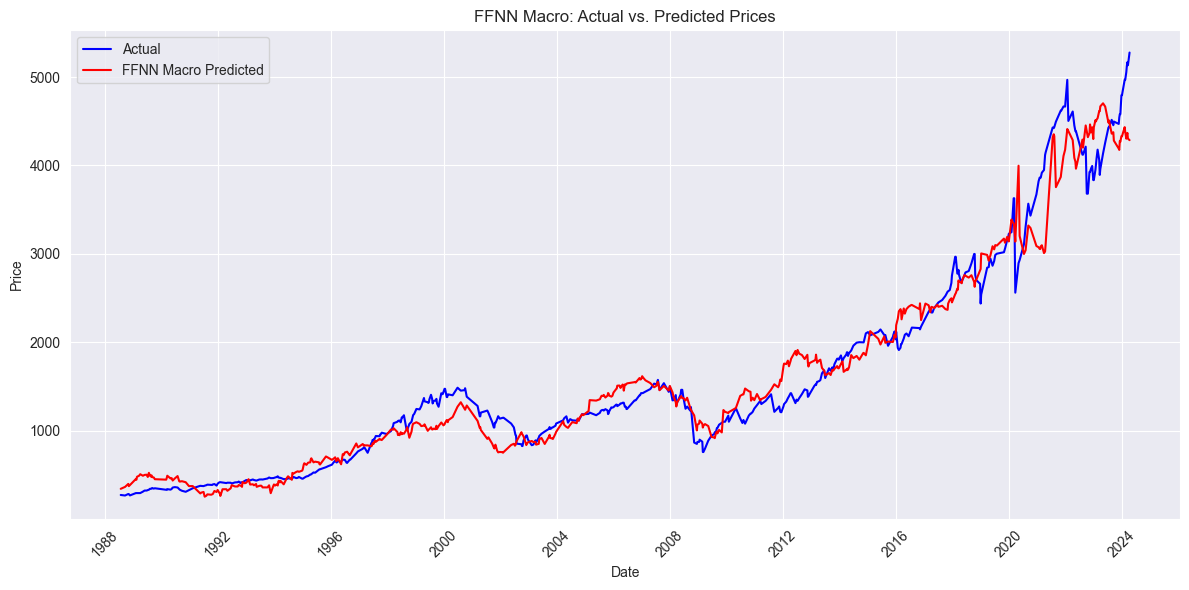

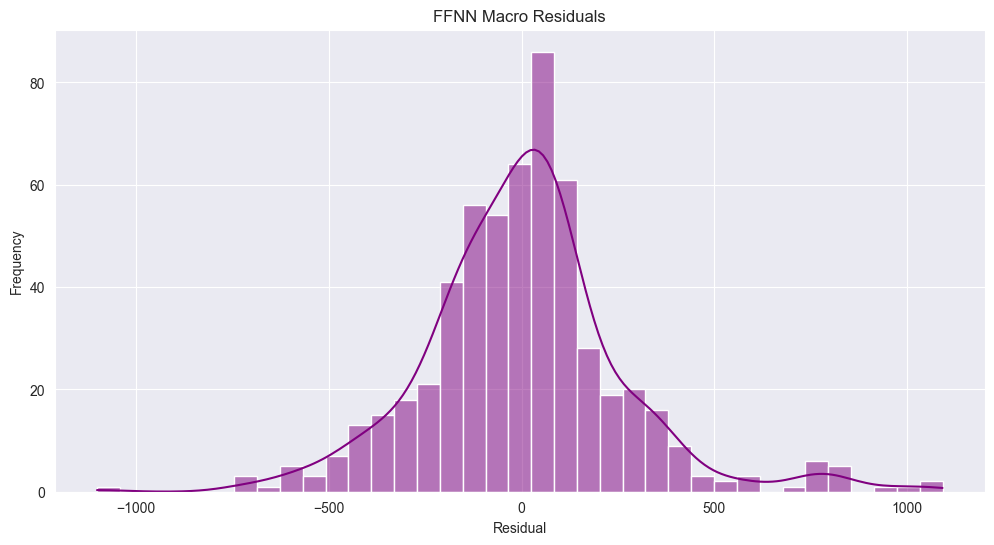

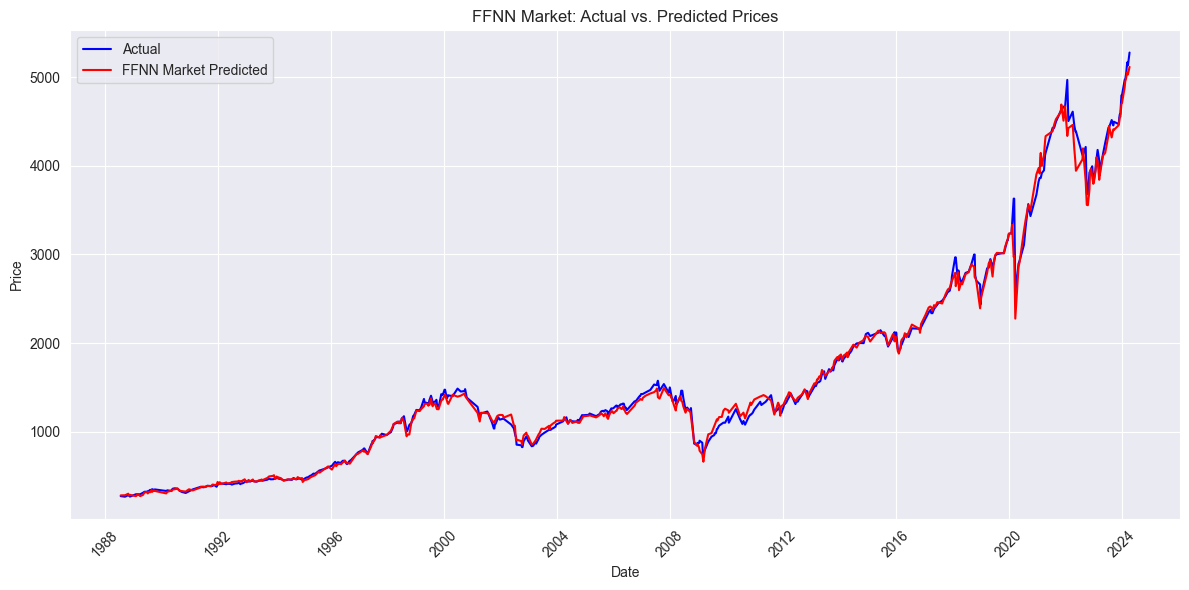

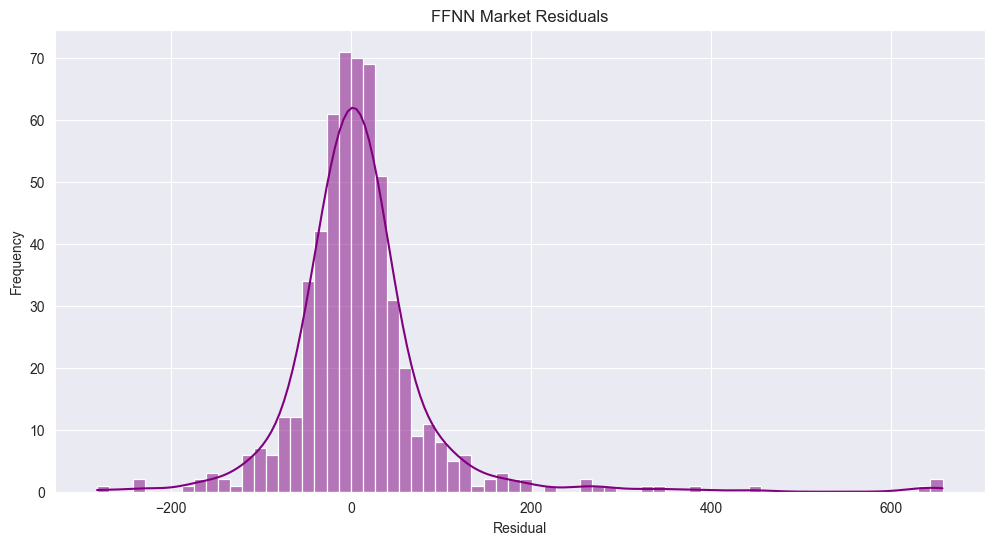

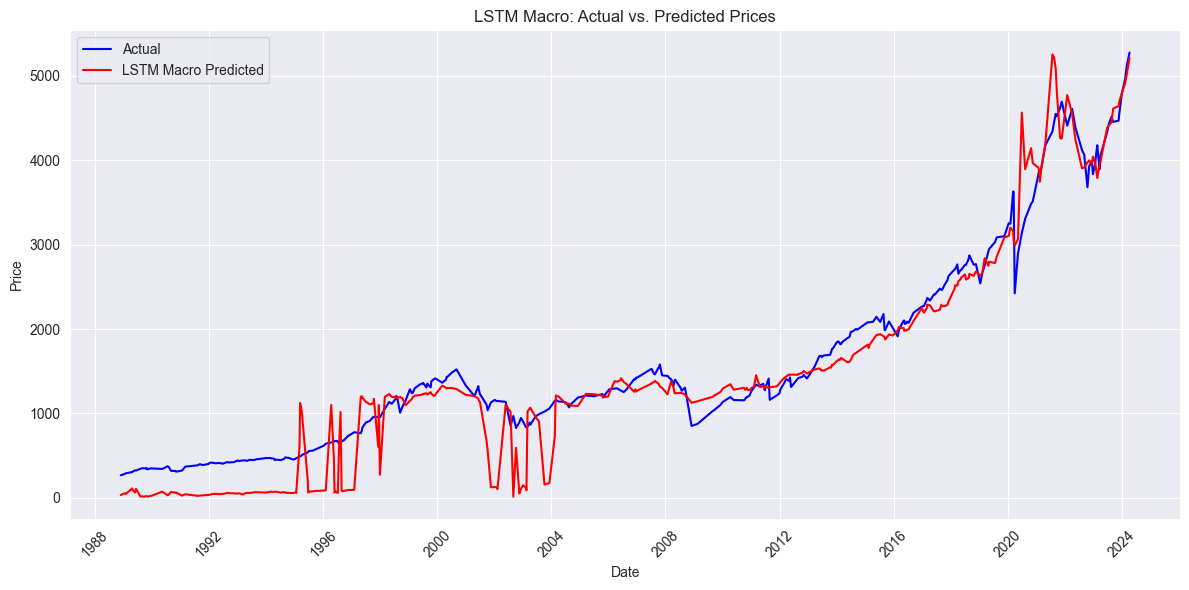

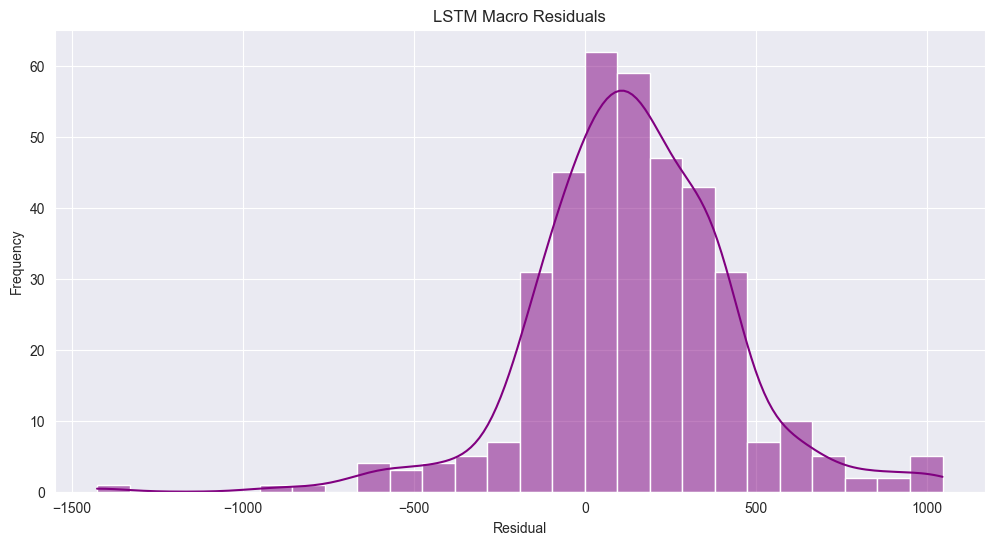

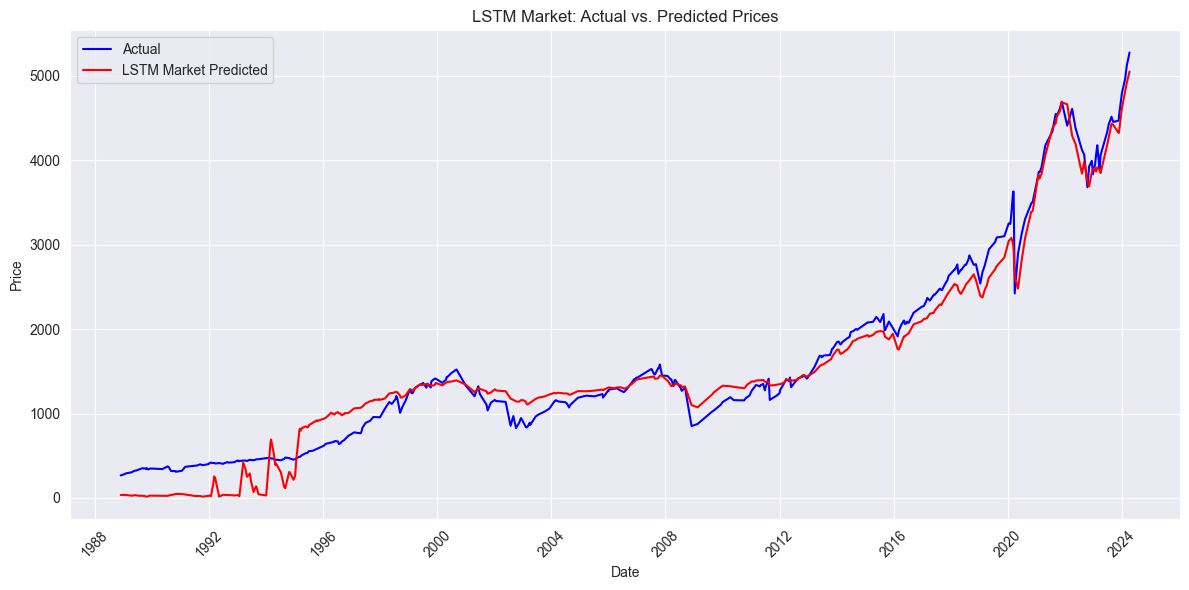

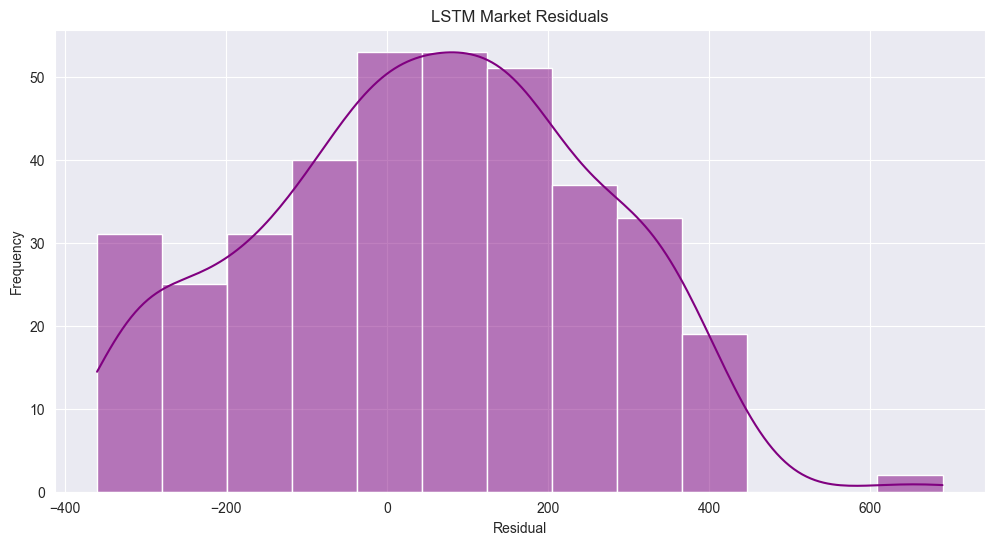

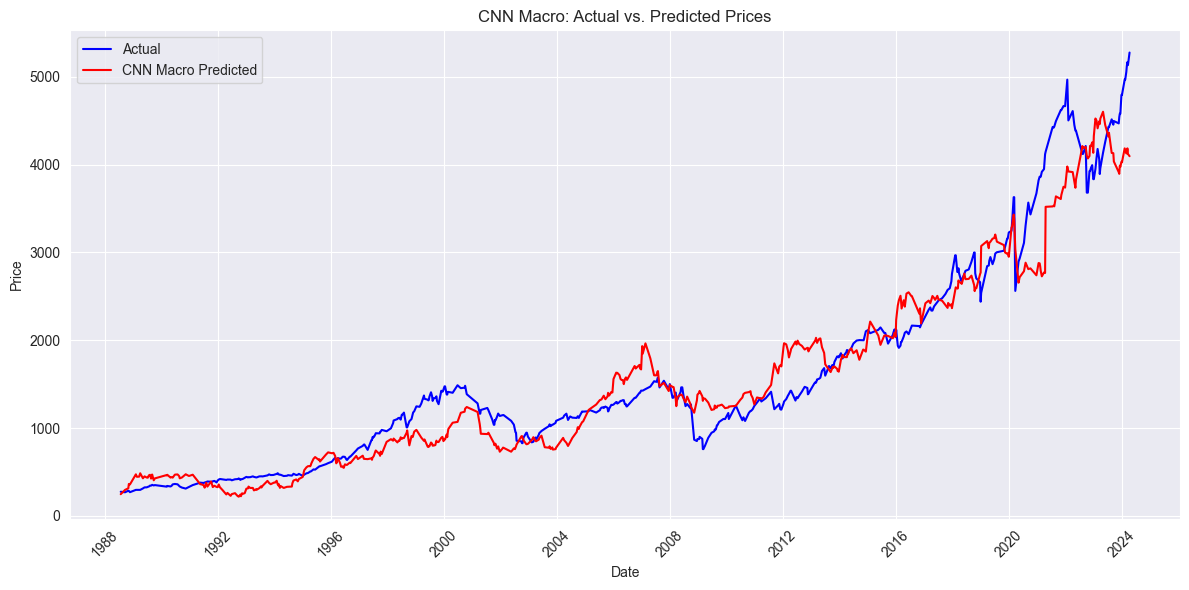

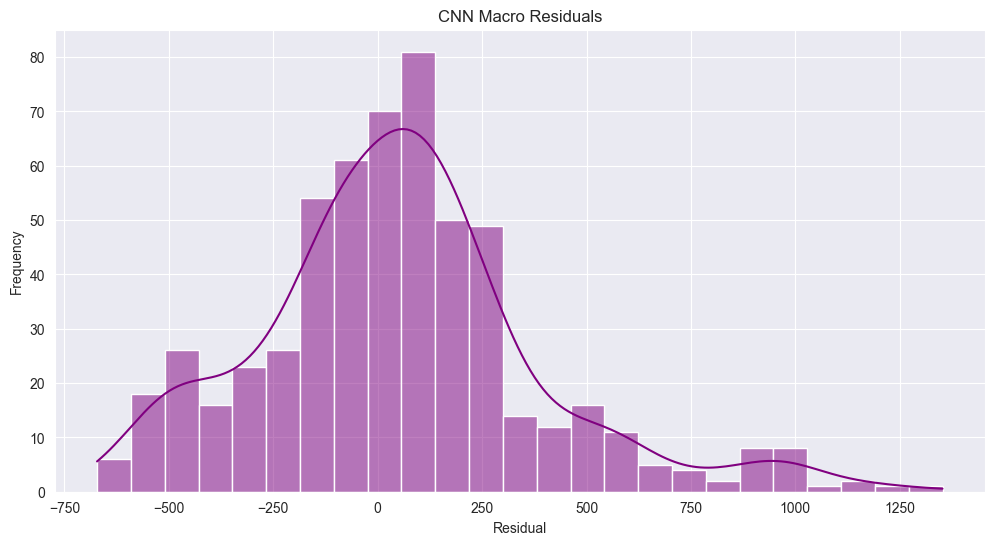

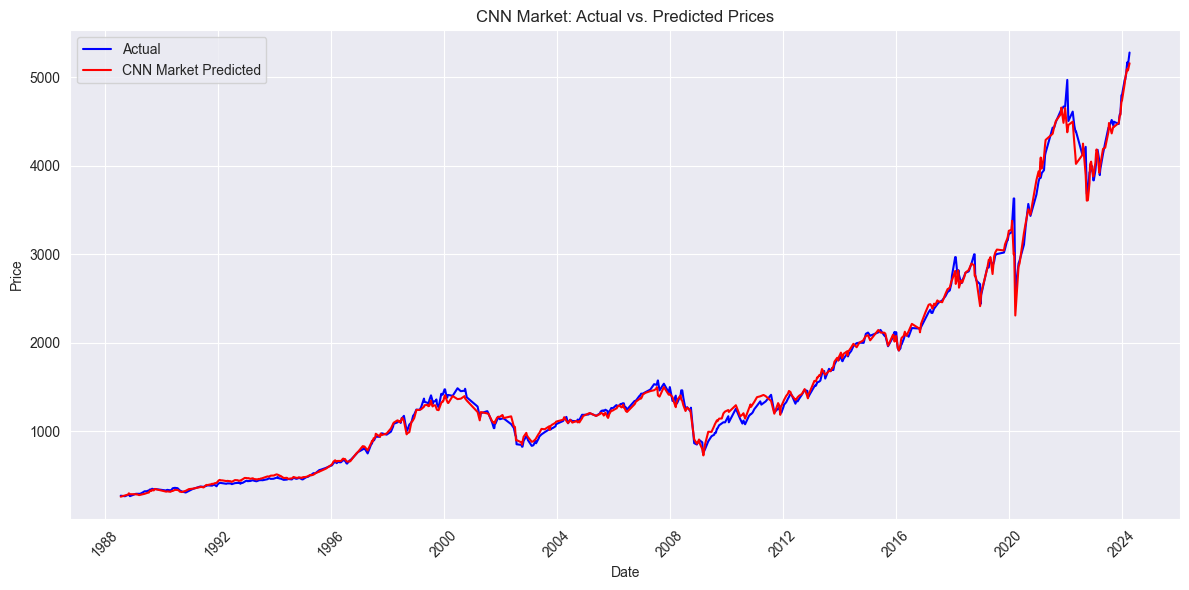

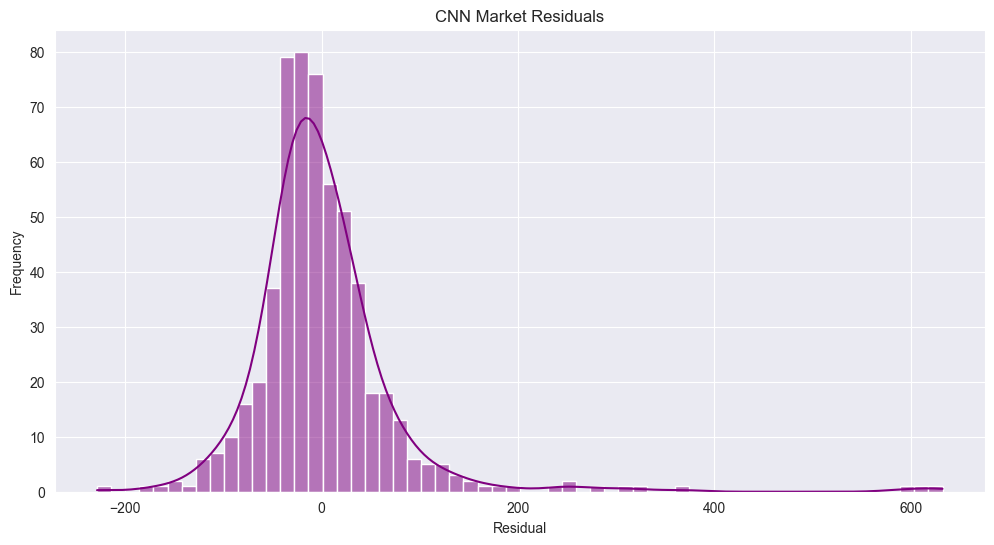

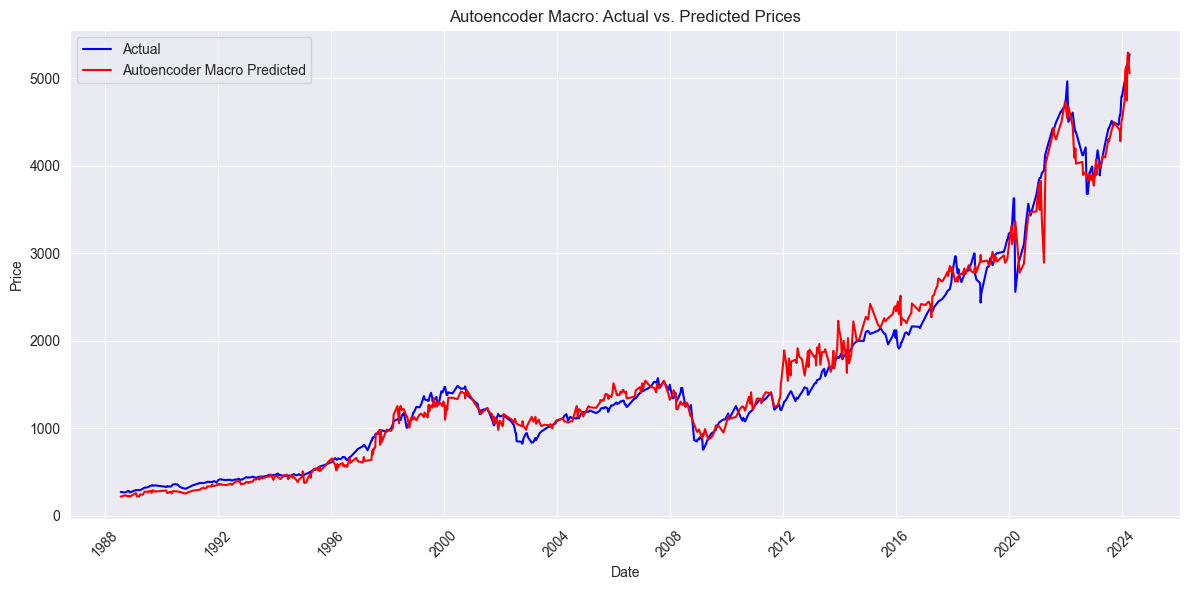

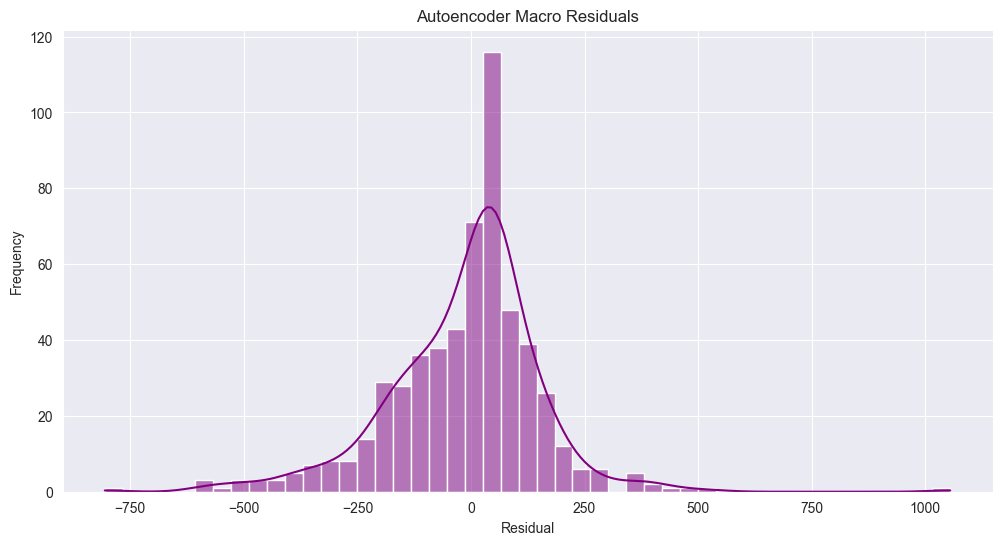

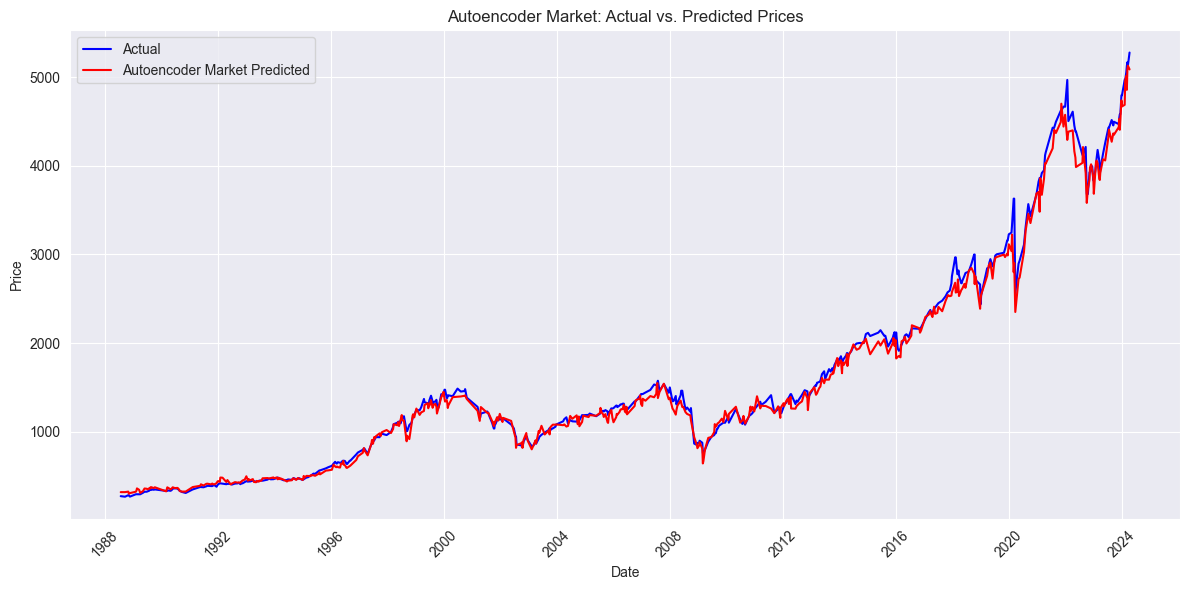

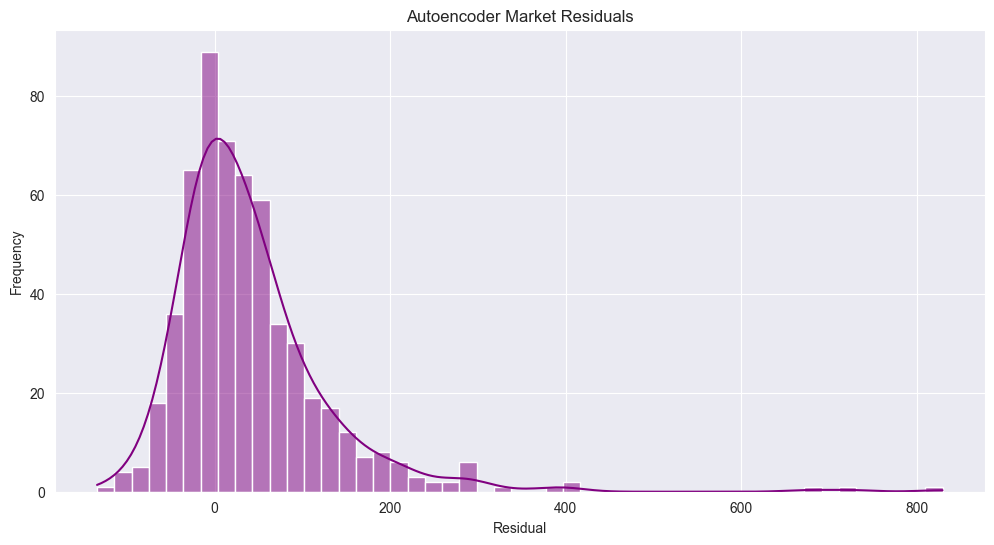

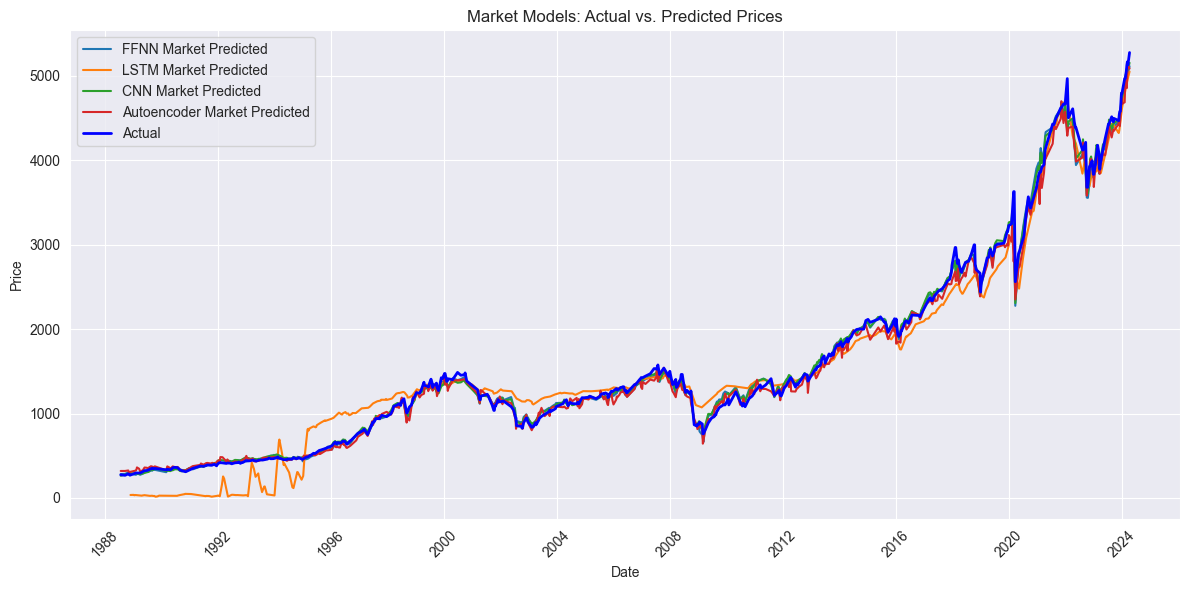

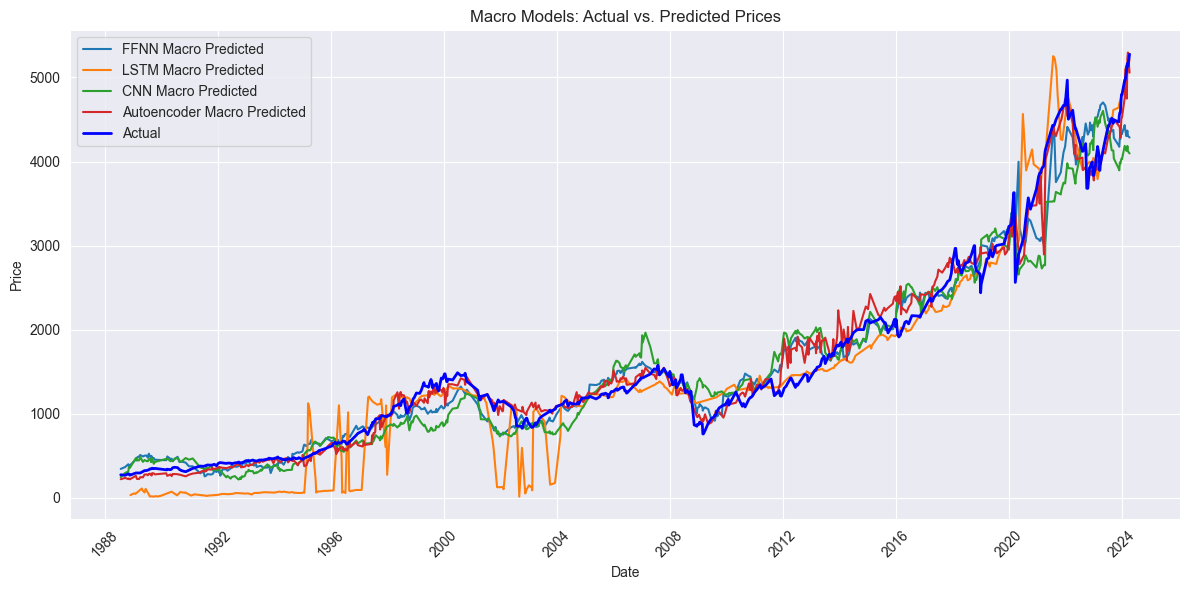

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


features_macro_scaled = scaler.fit_transform(features_macro)
# In sample predictions
scaler_cnn_pred = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_macro = scaler_cnn_pred.fit_transform(X_train_macro)

# In sample predictions
ffnn_macro_train_predictions = ffnn_model_macro.predict(X_train_macro)
lstm_macro_train_predictions = lstm_model_macro.predict(X_train_macro_prepared)
cnn_macro_train_predictions = cnn_model_macro.predict(X_train_scaled_macro)
autoencoder_macro_train_predictions = ae_prediction_model_macro.predict(X_train_macro_encoded)

scaler_cnn_pred = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_market = scaler_cnn_pred.fit_transform(X_train_market)

# In sample predictions
ffnn_market_train_predictions = ffnn_model_market.predict(X_train_market)
lstm_market_train_predictions = lstm_model_market.predict(X_train_market_prepared)
cnn_market_train_predictions = cnn_model_market.predict(X_train_scaled_market)
autoencoder_market_train_predictions = ae_prediction_model_market.predict(X_train_market_encoded)

def calculate_proportion_correct(predictions, actuals):
    predictions = predictions.flatten()
    actuals = actuals
    min_length = min(len(predictions), len(actuals))
    predictions = predictions[:min_length]
    actuals = actuals[:min_length]
    actual_directions = np.diff(actuals) > 0
    predicted_directions = np.diff(predictions) > 0
    correct_predictions = np.where(predicted_directions == actual_directions, 1, 0)
    proportion_correct = np.mean(correct_predictions)
    return proportion_correct

def calculate_ic(proportion_correct):
    return (2 * proportion_correct) - 1

def calculate_sharpe_ratio(predictions, actuals, risk_free_rate=0):
    predictions = np.array(predictions).flatten()
    actuals = np.array(actuals).flatten()
    
    strategy_returns = []
    for t in range(1, len(predictions)):
        if predictions[t-1] <= predictions[t] and actuals[t-1] <= actuals[t]:
            strategy_returns.append(actuals[t] - actuals[t-1])  # Long position
        elif predictions[t-1] > predictions[t] and actuals[t-1] > actuals[t]:
            strategy_returns.append(actuals[t-1] - actuals[t])  # Short position
        else:
            strategy_returns.append(0)  # No position
    
    strategy_returns = np.array(strategy_returns)
    
    mean_return = np.mean(strategy_returns)
    std_dev = np.std(strategy_returns)
    
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    
    return sharpe_ratio

def evaluate_model_performance(model_name, y_train, y_test, train_predictions, test_predictions):
    # Calculate metrics
    in_sample_mse = mean_squared_error(y_train, train_predictions)
    out_sample_mse = mean_squared_error(y_test, test_predictions)
    in_sample_r2 = r2_score(y_train, train_predictions)
    out_sample_r2 = r2_score(y_test, test_predictions)
    in_sample_mae = mean_absolute_error(y_train, train_predictions)
    out_sample_mae = mean_absolute_error(y_test, test_predictions)
    
    # Calculate proportion correct and IC
    in_sample_proportion_correct = calculate_proportion_correct(train_predictions, y_train)
    out_sample_proportion_correct = calculate_proportion_correct(test_predictions, y_test)
    in_sample_ic = calculate_ic(in_sample_proportion_correct)
    out_sample_ic = calculate_ic(out_sample_proportion_correct)
    
    sharpe_ratio = calculate_sharpe_ratio(test_predictions, y_test)
    
    return {
        "Model": model_name,
        "In-sample MSE": in_sample_mse,
        "Out-sample MSE": out_sample_mse,
        "In-sample R2": in_sample_r2,
        "Out-sample R2": out_sample_r2,
        "In-sample MAE": in_sample_mae,
        "Out-sample MAE": out_sample_mae,
        "In-sample IC": in_sample_ic,
        "Out-sample IC": out_sample_ic,
        "Sharpe Ratio": sharpe_ratio
    }

# Evaluate and compare all models
models_performance = []

# FFNN Macro
models_performance.append(evaluate_model_performance("FFNN Macro", y_train_macro.values, y_test_macro.values, ffnn_macro_train_predictions, ffnn_macro_predictions))

# FFNN Market
models_performance.append(evaluate_model_performance("FFNN Market", y_train_market.values, y_test_market.values, ffnn_market_train_predictions, ffnn_market_predictions))

# LSTM Macro
models_performance.append(evaluate_model_performance("LSTM Macro", y_train_macro_prepared, y_test_macro_prepared, lstm_macro_train_predictions, lstm_macro_predictions))

# LSTM Market
models_performance.append(evaluate_model_performance("LSTM Market", y_train_market_prepared, y_test_market_prepared, lstm_market_train_predictions, lstm_market_predictions))

# CNN Macro
models_performance.append(evaluate_model_performance("CNN Macro", y_train_macro.values, y_test_macro.values, cnn_macro_train_predictions, cnn_macro_predictions))

# CNN Market
models_performance.append(evaluate_model_performance("CNN Market", y_train_market.values, y_test_market.values, cnn_market_train_predictions, cnn_market_predictions))

# Autoencoder Macro
models_performance.append(evaluate_model_performance("Autoencoder Macro", y_train_macro.values, y_test_macro.values, autoencoder_macro_train_predictions, autoencoder_macro_predictions))

# Autoencoder Market
models_performance.append(evaluate_model_performance("Autoencoder Market", y_train_market.values, y_test_market.values, autoencoder_market_train_predictions, autoencoder_market_predictions))

# Convert to DataFrame for easy visualization
performance_df = pd.DataFrame(models_performance)
display(performance_df)

# Function to plot Actual vs. Predicted and Residuals
def plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions, dates):
    min_length = min(len(y_test), len(predictions), len(dates))
    y_test = y_test[:min_length]
    predictions = predictions[:min_length]
    dates = dates[:min_length]

    # Create a DataFrame with dates, actual values, and predictions
    df = pd.DataFrame({
        'Date': dates,
        'Actual': y_test,
        'Predicted': predictions.flatten()
    })
    df = df.sort_values('Date')

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue')
    plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted', color='red')
    plt.title(f'{model_name}: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    residuals = df['Actual'] - df['Predicted']
    plt.figure(figsize=(12, 6))
    sns.histplot(residuals, kde=True, color='purple')
    plt.title(f'{model_name} Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()

# Plot for each model
for model in models_performance:
    model_name = model["Model"]
    if "Macro" in model_name:
        if "LSTM" in model_name:
            y_test = y_test_macro_prepared
            predictions = lstm_macro_predictions
            dates = data.loc[test_indices, 'Date']
        elif "Autoencoder" in model_name:
            y_test = y_test_macro
            predictions = autoencoder_macro_predictions
            dates = data.loc[y_test_macro.index, 'Date']
        else:
            y_test = y_test_macro.values
            predictions = cnn_macro_predictions if model_name == "CNN Macro" else ffnn_macro_predictions
            dates = data.loc[y_test_macro.index, 'Date']
    else:
        if "LSTM" in model_name:
            y_test = y_test_market_prepared
            predictions = lstm_market_predictions
            dates = data.loc[test_indices, 'Date']
        elif "Autoencoder" in model_name:
            y_test = y_test_market
            predictions = autoencoder_market_predictions
            dates = data.loc[y_test_market.index, 'Date']
        else:
            y_test = y_test_market.values
            predictions = cnn_market_predictions if model_name == "CNN Market" else ffnn_market_predictions
            dates = data.loc[y_test_market.index, 'Date']

    plot_actual_vs_predicted_and_residuals(model_name, y_test, predictions, dates)

# Combined plot for all market predictions
def plot_combined_actual_vs_predicted_market(models_performance, data):
    plt.figure(figsize=(12, 6))
    for model in models_performance:
        model_name = model["Model"]
        if "Market" in model_name:
            if "LSTM" in model_name:
                y_test = y_test_market_prepared
                predictions = lstm_market_predictions
                dates = data.loc[test_indices, 'Date']
            elif "Autoencoder" in model_name:
                y_test = y_test_market
                predictions = autoencoder_market_predictions
                dates = data.loc[y_test_market.index, 'Date']
            else:
                y_test = y_test_market.values
                predictions = cnn_market_predictions if model_name == "CNN Market" else ffnn_market_predictions
                dates = data.loc[y_test_market.index, 'Date']

            min_length = min(len(y_test), len(predictions), len(dates))
            y_test = y_test[:min_length]
            predictions = predictions[:min_length]
            dates = dates[:min_length]

            # Create a DataFrame with dates, actual values, and predictions
            df = pd.DataFrame({
                'Date': dates,
                'Actual': y_test,
                'Predicted': predictions.flatten()
            })
            df = df.sort_values('Date')

            plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted')
    
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.title('Market Models: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Combined plot for all macro predictions
def plot_combined_actual_vs_predicted_macro(models_performance, data):
    plt.figure(figsize=(12, 6))
    for model in models_performance:
        model_name = model["Model"]
        if "Macro" in model_name:
            if "LSTM" in model_name:
                y_test = y_test_macro_prepared
                predictions = lstm_macro_predictions
                dates = data.loc[test_indices, 'Date']
            elif "Autoencoder" in model_name:
                y_test = y_test_macro
                predictions = autoencoder_macro_predictions
                dates = data.loc[y_test_macro.index, 'Date']
            else:
                y_test = y_test_macro.values
                predictions = cnn_macro_predictions if model_name == "CNN Macro" else ffnn_macro_predictions
                dates = data.loc[y_test_macro.index, 'Date']

            min_length = min(len(y_test), len(predictions), len(dates))
            y_test = y_test[:min_length]
            predictions = predictions[:min_length]
            dates = dates[:min_length]

            # Create a DataFrame with dates, actual values, and predictions
            df = pd.DataFrame({
                'Date': dates,
                'Actual': y_test,
                'Predicted': predictions.flatten()
            })
            df = df.sort_values('Date')

            plt.plot(df['Date'], df['Predicted'], label=model_name + ' Predicted')
    
    plt.plot(df['Date'], df['Actual'], label='Actual', color='blue', linewidth=2)
    plt.title('Macro Models: Actual vs. Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_combined_actual_vs_predicted_market(models_performance, data)
plot_combined_actual_vs_predicted_macro(models_performance, data)


- The FFNN Market model consistently performs the best across most metrics, indicating strong generalization and predictive capabilities for market data.
- The CNN Macro model performs the worst, suggesting difficulties in capturing the complexities of macroeconomic data with its current architecture or parameters.
- The LSTM Macro model, despite having higher MSE values, shows a high Sharpe Ratio, indicating good risk-adjusted returns, which might be valuable in certain financial applications.

We utilized artificial intelligence for both the development of the code and the composition of the paper, leveraging its advanced capabilities to enhance the accuracy, efficiency, and overall qualiy of our work.